# Import and initialize

## Importing modules

In [1]:
%matplotlib notebook

from IPython.display import clear_output

import sys
sys.path.append(r"D:\OneDrive\BF3\Code");
sys.path.append(r"D:\OneDrive\BF3\Code\labtools-master")

import os
import time
import datetime
import numpy as np
import matplotlib as mpl
# import utils

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

# from labtools import mplplots; reload(mplplots)
# from labtools.mplplots.init_nb_plotting import *
# from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.database import initialise_database, get_DB_location


from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id

from pytopo.qctools import instruments as instools

#from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

# from MDAC import MDAC 
# from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A

#from qcodes.instrument_drivers.stanford_research.SR860 import SR860
#from qcodes.instrument_drivers.QuTech.IVVI import IVVI
#from qcodes.instrument_drivers.yokogawa.GS200 import GS200

from pytopo.sweep import sweep, measure, nest, chain, szip, getter, setter, time_trace, do_experiment
from pytopo.qctools.instruments import create_inst

In [2]:
qc.config.subscription.default_subscribers = [] # no plottr needed

## Database configuration

In [3]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [4]:
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_%Y-%m-%d.db')
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## Wiring check

In [5]:
sys.path.append(r"D:\OneDrive\BF3\Code\BF3")
from QT3_PCB.pad_conversion import Gen5_to_BoB

In [6]:
Gen5_to_BoB(45,11,17,15,32)

pad 45 is matrix element(3, 15)
pad 11 is matrix element(4, 20)
pad 17 is matrix element(4, 17)
pad 15 is matrix element(4, 18)
pad 32 is matrix element(3, 9)


[(3, 15), (4, 20), (4, 17), (4, 18), (3, 9)]

## Initialize instruments

In [5]:
station = Station()

### Lock-in

In [6]:
from qcodes.instrument_drivers.stanford_research.SR865 import SR865
lockin1 = create_inst(SR865, "lockin1", "GPIB0::5::INSTR")
lockin1.amplitude.vals._min_value = 0
# lockin2 = create_inst(SR865, "lockin2", "GPIB0::5::INSTR")
# lockin2.amplitude.vals._min_value = 0
# lockin3 = create_inst(SR865, "lockin3", "GPIB0::6::INSTR")
# lockin3.amplitude.vals._min_value = 0
# lockin4 = create_inst(SR865, "lockin4", "GPIB0::7::INSTR")
# lockin4.amplitude.vals._min_value = 0

station = qc.Station(lockin1) #, lockin2, lockin3, lockin4)

Connected to: Stanford_Research_Systems SR860 (serial:003214, firmware:V1.47) in 0.15s


In [6]:
lockin2 = create_inst(SR865, "lockin2", "GPIB0::5::INSTR")
lockin2.amplitude.vals._min_value = 0
lockin3 = create_inst(SR865, "lockin3", "GPIB0::6::INSTR")
lockin3.amplitude.vals._min_value = 0
lockin4 = create_inst(SR865, "lockin4", "GPIB0::7::INSTR")
lockin4.amplitude.vals._min_value = 0

station.add_component(lockin2)
station.add_component(lockin3)
station.add_component(lockin4)

Connected to: Stanford_Research_Systems SR860 (serial:003214, firmware:V1.47) in 0.07s
Connected to: Stanford_Research_Systems SR860 (serial:003223, firmware:v1.51) in 0.07s
Connected to: Stanford_Research_Systems SR860 (serial:003105, firmware:V1.47) in 0.07s


'lockin4'

In [8]:
def show_lockin_status(lockin_instance):
    print('==={} status:==='.format(lockin_instance.name))
    print('Excitation amplitude = {}V'.format(lockin_instance.amplitude()))
    print('DC bias = {}V'.format(lockin_instance.sine_outdc()))
    print('Frequency = {}Hz'.format(lockin_instance.frequency()))
    print('Phase = {}deg'.format(lockin1.phase()))
    print('X = {}V'.format(lockin1.X()))
    print('Y = {}V'.format(lockin1.Y()))
    print('R = {}V'.format(lockin1.R()))
    print('P = {}deg\n'.format(lockin1.P()))

In [9]:
for equip_name, equip_instance in station.components.items():
    if 'SR860' in [s for d, s in equip_instance.get_idn().items()]:
        show_lockin_status(equip_instance)

===lockin1 status:===
Excitation amplitude = 0.0V
DC bias = 0.0V
Frequency = 0.00070770055754Hz
Phase = -180.0deg
X = -2.8870292681e-06V
Y = 8.1503378169e-05V
R = 8.1554462668e-05V
P = 92.024291992deg



In [10]:
lockin1.time_constant(0.1)
lockin2.time_constant(0.1)
lockin3.time_constant(0.1)
lockin4.time_constant(0.1)


### MDAC

In [10]:
sys.path.append(r"D:\OneDrive\BF3\Code\StationQ\MDAC\Driver")
from MDAC import MDAC
mdac = MDAC('MDAC1', 'ASRL4::INSTR')

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x32353532353551040028003E, firmware:1.5) in 5.19s


In [11]:
station.add_component(mdac)

'MDAC1'

In [12]:
sys.path.append(r"D:\OneDrive\BF3\Code\StationQ\MDAC\Driver")
from MDAC import MDAC
mdac2 = MDAC('MDAC2', 'ASRL6::INSTR')

Connected to: QNL Sydney MDAC (serial:0x32353532353551040037003E, firmware:1.5) in 5.50s


In [13]:
station.add_component(mdac2)

'MDAC2'

In [14]:
station.components

{'lockin1': <SR865: lockin1>, 'MDAC1': <MDAC: MDAC1>, 'MDAC2': <MDAC: MDAC2>}

### Yokogawa GS210

In [15]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
yoko1 = GS200("yoko1", "USB0::0x0B21::0x0039::91T926460::INSTR")

Connected to: YOKOGAWA GS210 (serial:91T926460, firmware:2.02) in 0.03s


In [16]:
station.add_component(yoko1)

[yoko1(GS200)] Snapshot: Could not update parameter: current_range
[yoko1(GS200)] Snapshot: Could not update parameter: current


'yoko1'

In [32]:
yoko1.on()

In [18]:
yoko_ramp_step = 1e-6 # in V
yoko_ramp_delay = 1e-6 # in s
def yoko1_ramp_raw(voltage): 
    yoko1.ramp_voltage(voltage, yoko_ramp_step, yoko_ramp_delay)
yoko1_ramp = setter(("yoko1_ramp", "V"))(yoko1_ramp_raw)

In [31]:
yoko1_ramp(0)

{'yoko1_ramp': 0}

In [17]:
yoko1.voltage()

0.0

### Keysight DMM

In [19]:
from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0301::MY57505052::INSTR", force_new_instance=True)

station.add_component(key1)

Connected to: Keysight Technologies 34465A (serial:MY57505052, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.45s


'key1'

In [46]:
key2 = create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0301::MY57505146::INSTR", force_new_instance=True)

station.add_component(key2)

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [36]:
key3 = create_inst(Keysight_34465A, "key3", "USB0::0x2A8D::0x0101::MY57505157::INSTR", force_new_instance=True)

station.add_component(key3)

Connected to: Keysight Technologies 34465A (serial:MY57505157, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.21s


'key3'

### Magnet

Check that the magnet is the "right" one and so the parameters (coil constant and so on...)

In [64]:
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430,AMI430_3D

In [65]:
ami_x = instools.create_inst(AMI430, "AMI430_x", "169.254.178.28", port = 7180, has_current_rating=True)
# ami_y = instools.create_inst(AMI430, "AMI430_y", "169.254.175.39", port = 7180, has_current_rating=True)
ami_z = instools.create_inst(AMI430, "AMI430_z", "169.254.137.107", port = 7180, has_current_rating=True)

ramp_limit_multiplier = 0.6
ami_x.current_ramp_limit(0.1805*ramp_limit_multiplier) #for QT3 magnet 0.1802
ami_x.coil_constant(0.01464)  #for QT3 magnet 0.01466
ami_x.current_rating(68.31)  #for QT3 magnet 68.21

# ami_y.current_ramp_limit(0.1810*ramp_limit_multiplier) #for QT3 magnet 0.1784
# ami_y.coil_constant(0.01477) #for QT3 magnet 0.01464
# ami_y.current_rating(67.7) #for QT3 magnet 68.31

ami_z.current_ramp_limit(0.0760*ramp_limit_multiplier) #for QT3 magnet 0.0775
ami_z.coil_constant(0.0836)  #for QT3 magnet 0.0818
ami_z.current_rating(71.77)  #for QT3 magnet 73.35

# ami = instools.create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)
# ami_3d = AMI430_3D("AMI_3D_1", ami_x, ami_y, ami_z, 1);

Connected to: AMERICAN MAGNETICS INC. 430 (serial:170029, firmware:2.59) in 1.14s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170027, firmware:2.59) in 1.11s


d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\american_magnetics\AMI430.py:407: AMI430Warning: Increasing maximum ramp rate: we have a default current ramp rate limit of 0.1 A/s. We do not want to ramp faster than a set maximum so as to avoid quenching the magnet. A value of 0.1 A/s seems like a safe, conservative value for any magnet. Change this value at your own responsibility after consulting the specs of your particular magnet
  warn(warning_message, category=AMI430Warning)


In [67]:
station.add_component(ami_x)
station.add_component(ami_z)

[AMI430_x(AMI430)] Snapshot: Could not update parameter: current_rating
[AMI430_x(AMI430)] Snapshot: Could not update parameter: field_rating
[AMI430_z(AMI430)] Snapshot: Could not update parameter: current_rating
[AMI430_z(AMI430)] Snapshot: Could not update parameter: field_rating


'AMI430_z'

In [69]:
print(ami_x.ramp_rate())
print(ami_x.ramp_rate_units())
print(ami_x.field())

0.0005
seconds
4.27e-05


In [66]:
print(ami_x.field())
# print(ami_y.field())
print(ami_z.field())

3.93e-05
0.0010467


In [161]:
ami_x.field(0.02)

In [168]:
ami_3d.spherical([0.02,30,-90])

KeyboardInterrupt: 

In [169]:
ami_3d.spherical_measured()

[0.017351588402794715, 0.88895443399450957, -89.765880361469726]

In [163]:
print(ami_3d.field_measured())
print(ami_3d.phi_measured())
print(ami_3d.theta_measured())

0.0199869162036
-0.15159321912
89.8962391492


In [170]:
ami_x.field()
ami_y.field()
ami_z.field()

0.0173291

In [190]:
ami_y.field()

-7.02e-05

In [191]:
ami_z.ramp_to(0)

In [148]:
print(ami_x.ramp_rate())
print(ami_y.ramp_rate())
print(ami_z.ramp_rate())
print(ami_x.ramp_rate_units())
print(ami_z.current_ramp_limit())
#30.1802*ramp_limit_multiplier
print(ami_x.field())
print(ami_y.field())
print(ami_z.field())
print (ami_3d.field_measured())
print(ami_3d.phi_measured())
ami_3d.theta_measured()

0.0004
0.0001
0.001
seconds
0.045599999999999995
0.106398
0.0001031
7.9e-06
0.106353059213
0.0496934723405


89.980806344603749

In [153]:
ami_3d.theta(90)

In [154]:
ami_3d.field(0.01)

KeyboardInterrupt: 

### Thermometer using BF logs

In [47]:
#set the path here of the shared desktop file
BF_PC_PATH = '\\\\MININT-ETA6HHA\\Desktop\\BF Log Files\\' 
print('Path of network drive(set this manually dear USER): ', BF_PC_PATH)
class Thermometer(Instrument):
    
    def __init__(self, name, **kw):
        super().__init__(name, **kw)        
        self.add_parameter('temperature', get_cmd=self._get_temperature, set_cmd=None, unit='K')
        
        self.add_parameter('counter', get_cmd=self._counter, set_cmd=None, unit='')
        self._ind = 0
        
    def _counter(self):
        self._ind += 1
        return self._ind
    def _get_temperature(self):
        ts = datetime.datetime.today()
        ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
        pth = BF_PC_PATH + ds + '\\CH9 T '+ds+'.log'
        time.sleep(0.1)
        try:
            T = np.loadtxt(pth, usecols = (2), delimiter = ',')[-1]
        except: # in the first few seconds of a day, a new log file hasn't been created
            ts = datetime.datetime.today() - datetime.timedelta(days=1) # use the last entry in the previous day
            ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
            pth = BF_PC_PATH + ds + '\\CH9 T '+ds+'.log'
            T = np.loadtxt(pth, usecols = (2), delimiter = ',')[-1]
        return T
    
        
    
T_probe = create_inst(Thermometer, 'T_probe', force_new_instance=True)
T_probe.temperature()



Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


0.0

In [48]:
T_probe.temperature()


0.0

### Lakeshore

In [20]:
from qcodes.instrument_drivers.Lakeshore.lakeshore_base import *
from qcodes.instrument_drivers.Lakeshore import Model_372

In [59]:
ls = instools.create_inst(Model_372.Model_372, 'lakeshore_372_1', 'TCPIP::169.254.132.9::7777::SOCKET')
h = ls.sample_heater

Connected to: LSCI 372 (serial:LSA21E7, firmware:1.3) in 0.12s


In [90]:
# Specify heater channel
heater_channel = 1;
reader_channel = 9;

# Set auto range of heater to enabled = 'current'
heater = ls.channels[heater_channel-1];
heater.auto_range('current')

# PID setup
h.P(1)
h.I(2)
h.D(2)
h.input_channel(heater_channel)
h.setpoint(0) # initialize setpoint to 0 for safety
h.mode('closed_loop')
max_T = [0.014, 0.019, 0.05, 0.15, 0.49, 1.5, 4.5, 10];
h.range_limits(max_T)

In [91]:
# h.blocking_t()
print(h.output_range(), ls.channels[reader_channel-1].temperature())

off 0.0270512


In [ ]:
for i in range(30):
    print(h.output_range(), ls.channels[heater_channel-1].temperature())
    time.sleep(1)

In [22]:
for kk in range (10):
    print(ls.ch09.temperature())
    time.sleep(0.2)

0.026221
0.0262231
0.0262244
0.0262256
0.0262259
0.0262255
0.0262247
0.0262233
0.0262222
0.0262222


In [62]:
ls.ch09.temperature()

0.0274641

In [47]:
h.set_range_from_temperature(0.05)

'1mA'

In [54]:
h.

{'closed_loop': 5,
 'monitor_out': 1,
 'off': 0,
 'open_loop': 2,
 'still': 4,
 'warm_up': 6,
 'zone': 3}

In [37]:
h.blocking_t(0.05)

ZeroDivisionError: ('float division by zero', 'setting lakeshore_372_sample_heater_blocking_t to 0.05')

## Measurement functions

### MDAC ramping

In [20]:
gate_ramp_stepsize = 1e-3  #[V] previously was 1e-3
gate_ramp_delay = 0.01  #[s] previously was 0.01

def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)
    
def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    lockin1.amplitude(0)
    lockin1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    # Note: we do this in separate loops because we want to be sure that
    # no currents are running anywhere before switching the relays
    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')

def chs_safe(*channels):
    lockin1.amplitude(0)
    lockin1.sine_outdc(0)   
    print('setting mdac in safe mode')
    for ch in channels:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
    print('Done')
# set_mdac_in_safemode()

In [21]:
def initialize(*channels):
    for s in channels:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    #     ramp(g.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('close')
        s.dac_output('close')
    #     d.gnd('close')
    #     g.dac_output('close')
    #     g.smc('close')
    
def initialize_leakage(channels_to_close, channels_to_open):
    for s in channels_to_close:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('close')
        s.dac_output('close')
    for s in channels_to_open:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('open')
        s.dac_output('open')

### getters and setters

In [51]:
def mdac_PG_voltage_raw(voltage): 
    ramp(PG.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_PG_voltage = setter(("mdac_PG_voltage", "V"))(mdac_PG_voltage_raw)

def mdac_CUT_voltage_raw(voltage): 
    ramp(CUT.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_CUT_voltage = setter(("mdac_CUT_voltage", "V"))(mdac_CUT_voltage_raw)

def mdac_GATES_voltage_raw(voltage): 
    ramp(PG.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    ramp(CUT.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_GATES_voltage = setter(("mdac_GATES_voltage", "V"))(mdac_GATES_voltage_raw)

def mdac_TG1_voltage_raw(voltage): 
    ramp(TG1.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_TG1_voltage = setter(("mdac_TG1_voltage", "V"))(mdac_TG1_voltage_raw)

def mdac_TG2_voltage_raw(voltage): 
    ramp(TG2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_TG2_voltage = setter(("mdac_TG2_voltage", "V"))(mdac_TG2_voltage_raw)

def mdac_TG3_voltage_raw(voltage): 
    ramp(TG3.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_TG3_voltage = setter(("mdac_TG3_voltage", "V"))(mdac_TG3_voltage_raw)

def mdac_Bias_voltage_raw(voltage): 
    ramp(mdac_Bias.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_Bias_voltage = setter(("mdac_Bias_voltage", "V"))(mdac_Bias_voltage_raw)

def mdac_3TGs_voltage_raw(voltage): 
    ramp(TG1.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    ramp(TG2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    ramp(TG3.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_3TGs_voltage = setter(("mdac_3TGs_voltage", "V"))(mdac_3TGs_voltage_raw)

bias_ramp_stepsize = 1e-3  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]

@setter(("mdac_bias_voltage", "V"))
def mdac_bias_voltage(voltage): 
    voltage *= 790
    ramp(source.voltage, voltage, bias_ramp_stepsize, bias_ramp_delay)

@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage *= 100
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)
    
@setter(("lockin2_dc", "V"))
def lockin2_dc(voltage): 
    voltage *= 100
    ramp(lockin2.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@setter(("lockin3_dc", "V"))
def lockin3_dc(voltage): 
    voltage *= 100
    ramp(lockin3.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)
    
@setter(("lockin4_dc", "V"))
def lockin4_dc(voltage): 
    voltage *= 100
    ramp(lockin4.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)
    
@setter(("lockins_dc", "V"))
def lockins_dc(voltage): 
    voltage *= 100
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)
    ramp(lockin2.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)
    ramp(lockin3.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)
    
@setter(("yoko2_voltage", "V"))
def yoko2_voltage(voltage): 
    #voltage *= 790
    ramp(yoko2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter(("time_sweep", "a.u."))
def time_sweep(a): 
    time.sleep(0.001)
    
@setter(("datapoint", "a.u."))
def datapoint(a): 
    time.sleep(0)    
    
@setter(("field_sweep", "T"))
def field_sweep(a):
    time.sleep(0.001);

### Generators for field ramps

In [22]:
# Basically converts callable function to generator
def get_next(val):
    while 1:
        yield val();

# Generate linspace points until val() is outside of window        
def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
    linspace = np.linspace(start, stop, step)
    for value in linspace:

        if val() < (lowlim - eps) or val() > (highlim + eps):
            break

        yield value

# Sweep the field as long as val() is within the window
def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

    val = magnet.field;

    # To correct for overshoot since the last window sweep of size eps, sweep field back to either
    # lowlim or highlim, whichever the current field value is closest to, then begin
    if init_to_closest_lim:

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

        print('Initializing (blocking) field to {} T ...'.format(initlim))
        magnet.field(initlim);
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

    for field_val in get_next(val):
        if np.abs(field_val - finlim) < np.abs(eps):
                break

        yield field_val  

# Measurements

## MDAC Vbias testing and definitions

In [24]:
bias_ch.snapshot()
bias_ch.print_readable_snapshot()

MDAC1_chan6:
	parameter       value
--------------------------------------------------------------------------------
amplitude        :	0 (Vpp)
autosync         :	True 
bus              :	open 
dac_output       :	close 
default_ramprate :	0.001 (V/s)
divider          :	off 
filter           :	1 
frequency        :	0 (Hz)
gnd              :	open 
limit_max        :	5.086 (V)
limit_min        :	-5.0858 (V)
limit_rate       :	0.285 (V/s)
microd           :	open 
offset           :	0 (V)
period           :	0 (s)
phase            :	0 (Deg)
ramp_destination :	None (V)
ramp_rate        :	None (V/s)
smc              :	close 
voltage          :	0 (V)
voltage_raw      :	524280 (LSB)
waveform         :	off 


In [25]:
mdac.trigger0.snapshot()
mdac.trigger0.print_readable_snapshot()

MDAC1_trigger0:
	parameter value
--------------------------------------------------------------------------------
autosync  :	True 
direction :	up 
frequency :	0 (Hz)
period    :	0 (s)
phase     :	0 (Deg)


In [22]:
initialize(mdac.ch06)

In [23]:
bias_ch = mdac.ch06

In [303]:
bias_ch.divider('off')

In [29]:
bias_ch.awg_sine(13.73, 500e-6, 0)

In [302]:
bias_ch.voltage(0)

In [301]:
bias_ch.offset(0)

In [28]:
mdac.trigger0.start(13.73)

In [31]:
mdac.trigger0.stop()

In [27]:
bias_ch.limit_rate(100)

In [269]:
mdac.sync()

In [256]:
bias_ch.awg_square(13, 5e-3)

In [30]:
bias_ch.awg_off()

In [251]:
bias_ch.voltage()

0.0

In [257]:
mdac.ch09.limit_rate()

0.30000000000000004

In [222]:
bias_ch.voltage()

0.000504

In [235]:
bias_ch.awg_off()

In [121]:
bias_ch.offset(5e-2)

In [32]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


## Defining gates

In [41]:
TG1 = mdac.ch01
initialize(TG1)

TG2 = mdac.ch17
initialize(TG2)

TG3 = mdac.ch33
initialize(TG3)

In [56]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [103]:
mdac.ch57.voltage()

0.0

In [29]:
mdac.ch49.voltage()

0.0

In [66]:
mdac.ch33.voltage()

0.0

In [102]:
PG = mdac.ch57
initialize(PG)

In [81]:
CUT = mdac.ch49
initialize(CUT)

In [31]:
mdac_TG3_voltage(0)

{'mdac_TG3_voltage': 0}

In [89]:
mdac_CUT_voltage(0)

{'mdac_CUT_voltage': 0}

## Gate stability

In [52]:
#variables (standard units: Volts, seconds, Ohms)
gate = 0.23
Rseries = 23e3
device_name = "NS_400"

Bias = 10e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 1

keyNPLC = 10
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key2.NPLC(keyNPLC)
    lockin2.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin2_dc(Bias)
    lockin2.time_constant(time_constant)
    mdac_TG2_voltage(0)
    mdac_TG2_voltage(gate)
    time.sleep(3)
    
def cleanup(): 
    lockin2.amplitude(0)
    lockin2_dc(0)
    mdac_TG2_voltage(0)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(time_constant)
    key_raw1 = key2.volt()
    current_dc1 = -key_raw1/gain
    Vac1    = adder_atten*lockin2.amplitude()
    L1P     = lockin2.P()
    L1R     = lockin2.R()
    L1Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin2.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_time_sweep_Gate_{}V_Bias_{}mV/".format(gate, int(Bias*1000)) + device_name,
    nest(
        sweep(time_sweep, np.linspace(0, 1, 501)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
) 

Starting experimental run with id: 16


In [106]:
mdac_PG_voltage(0)

{'mdac_PG_voltage': 0}

## pinch-off

### single sweep

In [108]:
yoko1_ramp(0)

{'yoko1_ramp': 0}

In [86]:
lockin1.amplitude(0)
lockin1_dc(0)

{'lockin1_dc': 0}

In [91]:
#pinch-off variables (standard units: Volts, seconds, Ohms)
Vbegin = 1
Vend = 0
n_points = 201
Rseries = 13.4e3
device_name = "SS7"

bias = 10e-3 #takes into account attenuation of 100.
lockin_amplitude = 10e-6 # real voltage on device
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key1.NPLC(keyNPLC)
    lockin1.amplitude(lockin_amplitude / attenuation) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin1_dc(bias)
    lockin1.time_constant(time_constant)
    yoko1_ramp(Vbegin)
    time.sleep(3)
        
def cleanup(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
#     yoko1_ramp(0)

yoko_ramp_step = 2e-6 # in V
yoko_ramp_delay = 2e-7 # in s
def yoko1_ramp_raw(voltage): 
    yoko1.ramp_voltage(voltage, yoko_ramp_step, yoko_ramp_delay)
yoko1_ramp = setter(("yoko1_ramp", "V"))(yoko1_ramp_raw)

bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]
@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.7 * time_constant)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1    = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q383_Gate_sweep_Bias_{}mV/".format(int(bias*1000)) + device_name,
    nest(
        sweep(yoko1_ramp, np.linspace(Vbegin, Vend, n_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup
) 


Starting experimental run with id: 57


### double sweep

In [92]:
#pinch-off variables (standard units: Volts, seconds, Ohms)
Vbegin = -0.3
Vend = 1
n_points = 261
Rseries = 13.4e3
device_name = "SS7"

#bias = 10e-3 #takes into account attenuation of 100.
bias = 0
lockin_amplitude = 10e-6 # real voltage on device
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key1.NPLC(keyNPLC)
    lockin1.amplitude(lockin_amplitude / attenuation) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin1_dc(bias)
    lockin1.time_constant(time_constant)
    yoko1_ramp(Vbegin)
    time.sleep(3)
    
def cleanup_mid():
    pass

def setup_mid():
    lockin1_dc(bias)
    time.sleep(3)
        
def cleanup(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    yoko1_ramp(0)

yoko_ramp_step = 2e-6 # in V
yoko_ramp_delay = 2e-7 # in s
def yoko1_ramp_raw(voltage): 
    yoko1.ramp_voltage(voltage, yoko_ramp_step, yoko_ramp_delay)
yoko1_ramp = setter(("yoko1_ramp", "V"))(yoko1_ramp_raw)

bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]
@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.7 * time_constant)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1    = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q383_Gate_sweep_Bias_{}mV/".format(int(bias*1000)) + device_name,
    nest(
        sweep(yoko1_ramp, np.linspace(Vbegin, Vend, n_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup_mid
)

#bias = 0
bias = 10e-3

result = do_experiment(
    "Q383_Gate_sweep_Bias_{}mV/".format(int(bias*1000)) + device_name,
    nest(
        sweep(yoko1_ramp, np.linspace(Vend, Vbegin, n_points)),
        measure(measure_acdc)
    ),
    setup_mid,
    cleanup
)

Starting experimental run with id: 58
Starting experimental run with id: 59


In [28]:
#pinch-off variables (standard units: Volts, seconds, Ohms)
Vmin = -0.2
Vmax = 0.2
n_points = 41
Rseries = 13e3
device_name = "NS_260"

Bias = 10e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 1

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key1.NPLC(keyNPLC)
    lockin1.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin1_dc(Bias)
    lockin1.time_constant(time_constant)
    mdac_TG1_voltage(Vmin)
    time.sleep(3)
    
def cleanup_mid():
    time.sleep(1)

def setup_mid():
    time.sleep(1)
    
def cleanup(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    mdac_TG1_voltage(0)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(time_constant)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1    = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_Gate_sweep_Bias_{}mV/".format(int(Bias*1000)) + device_name,
    nest(
        sweep(mdac_TG1_voltage, np.linspace(Vmin, Vmax, n_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup_mid,
) 
result = do_experiment(
    "Q326zz_Gate_sweep_Bias_{}mV_backward/".format(int(Bias*1000)) + device_name,
    nest(
        sweep(mdac_TG1_voltage, np.linspace(Vmax, Vmin, n_points)),
        measure(measure_acdc)
    ),
    setup_mid,
    cleanup,
)

Starting experimental run with id: 1
Starting experimental run with id: 2


In [38]:
#pinch-off variables (standard units: Volts, seconds, Ohms)
Vmin = -0.2
Vmax = 0.8
n_points = 101
Rseries = 23e3
device_name = "NS_400"

Bias = 10e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key2.NPLC(keyNPLC)
    lockin2.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin2_dc(Bias)
    lockin2.time_constant(time_constant)
    mdac_TG2_voltage(Vmin)
    time.sleep(3)
    
def cleanup_mid():
    time.sleep(1)

def setup_mid():
    time.sleep(1)
    
def cleanup(): 
    lockin2.amplitude(0)
    lockin2_dc(0)
    mdac_TG2_voltage(0)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(time_constant)
    key_raw1 = key2.volt()
    current_dc1 = -key_raw1/gain
    Vac1    = adder_atten*lockin2.amplitude()
    L1P     = lockin2.P()
    L1R     = lockin2.R()
    L1Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin2.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_Gate_sweep_Bias_{}mV/".format(int(Bias*1000)) + device_name,
    nest(
        sweep(mdac_TG2_voltage, np.linspace(Vmin, Vmax, n_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup_mid,
) 
result = do_experiment(
    "Q326zz_Gate_sweep_Bias_{}mV_backward/".format(int(Bias*1000)) + device_name,
    nest(
        sweep(mdac_TG2_voltage, np.linspace(Vmax, Vmin, n_points)),
        measure(measure_acdc)
    ),
    setup_mid,
    cleanup,
)

Starting experimental run with id: 86
Starting experimental run with id: 87


In [43]:
#pinch-off variables (standard units: Volts, seconds, Ohms)
Vmin = -0.2
Vmax = 0.8
n_points = 101
Rseries = 18e3
device_name = "NSS_420_sourceNdrainS"

Bias = 10e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key3.NPLC(keyNPLC)
    lockin3.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin3_dc(Bias)
    lockin3.time_constant(time_constant)
    mdac_TG3_voltage(Vmin)
    time.sleep(3)
    
def cleanup_mid():
    time.sleep(1)

def setup_mid():
    time.sleep(1)
    
def cleanup(): 
    lockin3.amplitude(0)
    lockin3_dc(0)
    mdac_TG3_voltage(0)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(time_constant)
    key_raw1 = key3.volt()
    current_dc1 = -key_raw1/gain
    Vac1    = adder_atten*lockin3.amplitude()
    L1P     = lockin3.P()
    L1R     = lockin3.R()
    L1Y     = lockin3.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin3.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_Gate_sweep_Bias_{}mV/".format(int(Bias*1000)) + device_name,
    nest(
        sweep(mdac_TG3_voltage, np.linspace(Vmin, Vmax, n_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup_mid,
) 
result = do_experiment(
    "Q326zz_Gate_sweep_Bias_{}mV_backward/".format(int(Bias*1000)) + device_name,
    nest(
        sweep(mdac_TG3_voltage, np.linspace(Vmax, Vmin, n_points)),
        measure(measure_acdc)
    ),
    setup_mid,
    cleanup,
)

Starting experimental run with id: 88
Starting experimental run with id: 89


In [45]:
mdac_TG1_voltage(0)

{'mdac_TG1_voltage': 0}

## V-bias sweep

In [55]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 201
Rseries = 13.4e3
device_name = "floating_NIS_3"
bias = 1e-3

lockin_amplitude = 5e-6 # real voltages on the device
time_constant = 0.1
keyNPLC = 1
gain = 1e6
source_attenuation = 1e-2

# yoko1_ramp(0.5)
# lockin1_dc(-bias)

def setup():
    key1.NPLC(keyNPLC)
    lockin1.amplitude(lockin_amplitude / source_attenuation)
    lockin1_dc(-bias)
    lockin1.time_constant(time_constant)
    time.sleep(3)
    
def cleanup(): 
#     pass
    lockin1.amplitude(0)
    lockin1_dc(0)
    
bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.02  #[s]

@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= source_attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(1.7 * time_constant)
    if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
        time.sleep(2)
    if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
        time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    Vac1     = attenuation * lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X / gain
    try:
        g1 = 12906 / (Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "NIS_therm_Vbias_2t/" + device_name,
    nest(
        sweep(lockin1_dc, np.linspace(-bias, bias, n_bias_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 4


## Basel amps

See drawing for circuit

DC bias and lock-in excitation are still both applied by the lock-in output and go into the bias-offset input of the current amp. Sample is connected via the amp current input in a 2-terminal setup.

The bias-offset input has a built-in 1e-2 attenuation. This applies to both ac and dc. The offset is also output after going throught the device and the current amp.

$$
V_\mathrm{out} = R_\mathrm{gain} \times \frac{V_\mathrm{bias}/100 + V_\mathrm{thermal\ offset}}{R_\mathrm{device}}
$$

$$
v_\mathrm{out} = R_\mathrm{gain} \times \frac{v_\mathrm{exc} / 100}{R_\mathrm{dev}}
$$


Notes: some problems while using a 1MOhm resistor and 100mV excitation (before attenuation) for testing (19 July 2019): 

- 1e5 gain -> 1mV output
- 1e6 gain -> 2mV output
- 1e7 gain -> 10mV output
- 1e8 gain -> 100mV output

For this reason, before further tests establish the integrity of the whole circuit, we should limit ourselves to 1e7 gain. However, the excessively amplified DC offset will result in ~volt-level output offsets and therefore keysight DMM range should be set to 10V.

In [73]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 2001
Rseries = 6.7e3
device_name = "grounded_NIS_2"
bias = 1e-3
bias_offset = -0.65e-3

lockin_amplitude = 10e-6 # real voltages on the device
time_constant = 0.3
keyNPLC = 1
gain = 1e7
source_attenuation = 1e-2

# yoko1_ramp(0.5)
# lockin1_dc(-bias)

def setup():
    key1.NPLC(keyNPLC)
    lockin1.amplitude(lockin_amplitude / source_attenuation)
    lockin1_dc(-bias)
    lockin1.time_constant(time_constant)
    time.sleep(3)
    
def cleanup(): 
#     pass
    lockin1.amplitude(0)
    lockin1_dc(0)
    
bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.02  #[s]

@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= source_attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(1.7 * time_constant)
    if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
        time.sleep(2)
    if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
        time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    Vac1     = attenuation * lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X / gain
    try:
        g1 = 12906 / (Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "NIS_therm_Vbias_2t/" + device_name,
    nest(
        sweep(lockin1_dc, np.linspace(-bias+bias_offset, bias+bias_offset, n_bias_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 13


### DC only

In [78]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 2001
Rseries = 6.7e3
device_name = "grounded_NIS_2"
bias = 1e-3
bias_offset = -0.65e-3

keyNPLC = 1
gain = 1e7
source_attenuation = 1e-2

def setup():
    key1.NPLC(keyNPLC)
    lockin1_dc(-bias)
    time.sleep(3)
    
def cleanup(): 
    lockin1_dc(0)
    
bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.02  #[s]

@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= source_attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'))
def measure_dc_only(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(0.018*keyNPLC)
    if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
        time.sleep(2)
    if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
        time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    
    result  = current_dc1, key_raw1
    return result

result = do_experiment(
    "NIS_therm_Vbias_2t_dc_only_magnets_off/" + device_name,
    nest(
        sweep(lockin1_dc, np.linspace(-bias+bias_offset, bias+bias_offset, n_bias_points)),
        measure(measure_dc_only)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 17


### Fridge floating

1M$\Omega$ connection from fridge to the grid, almost certainly via the magnet.

Using Yokogawa as the DC bias source, Basel preamp and Keysight DMM. All three are isolated from the grid at their inputs/outpus. Measured 1M$\Omega$ between Yokogawa and lockin, and 0 between Yokogawa and fridge.

Ithaco when powered via the line (it's truely/physically floating when battery powered), lockin and MDAC are all directly connected to the grid. If any of these equipements are hooked up to the devices, the 50Hz directly couple to the fridge.



In [88]:
yoko1_ramp(0)

{'yoko1_ramp': 0}

In [87]:
key1.volt()

-0.563241402

In [86]:
yoko_ramp_step = 2e-6 # in V
yoko_ramp_delay = 2e-6 # in s
def yoko1_bias_ramp_raw(voltage): 
    yoko1.ramp_voltage(voltage*100, yoko_ramp_step, yoko_ramp_delay) # intended for Basel amp bias atten=1e-2
yoko1_bias_ramp = setter(("yoko1_bias_ramp", "V"))(yoko1_bias_ramp_raw)

In [93]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 10001
Rseries = 6.7e3
device_name = "grounded_NIS_2"
bias = 1e-3
bias_offset = -0.65e-3

keyNPLC = 1
gain = 1e7
source_attenuation = 1e-2

def setup():
    key1.NPLC(keyNPLC)
    yoko1_bias_ramp(-bias)
    time.sleep(3)
    
def cleanup(): 
    yoko1_bias_ramp(0)
    
# omitting bias ramp definitions! 

@getter(('current', 'A'), ('raw_voltage_dc', 'V'))
def measure_dc_only(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(0.018*keyNPLC)
#     if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
#         time.sleep(2)
#     if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
#         time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    
    result  = current_dc1, key_raw1
    return result

result = do_experiment(
    "NIS_therm_Vbias_2t_onlyDC_magnetsOFF_fridgeGND_lockinInputCONNECTEDtoDMM_lockinConnectedToSCOPE/" + device_name,
    nest(
        sweep(yoko1_bias_ramp, np.linspace(-bias+bias_offset, bias+bias_offset, n_bias_points)),
        measure(measure_dc_only)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 22


### Comparing lockin dc output and Yokogawa

In [94]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 2001
Rseries = 6.7e3
device_name = "source_to_meter"
bias = 1e-3
bias_offset = 0

keyNPLC = 1
gain = 1e7
source_attenuation = 1e-2

def setup():
    key1.NPLC(keyNPLC)
    lockin1_dc(-bias)
    time.sleep(3)
    
def cleanup(): 
    lockin1_dc(0)
    
bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.02  #[s]

@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= source_attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'))
def measure_dc_only(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(0.018*keyNPLC)
    if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
        time.sleep(2)
    if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
        time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    
    result  = current_dc1, key_raw1
    return result

result = do_experiment(
    "lockin_DCsource_measure/" + device_name,
    nest(
        sweep(lockin1_dc, np.linspace(-bias+bias_offset, bias+bias_offset, n_bias_points)),
        measure(measure_dc_only)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 23


In [95]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 2001
Rseries = 6.7e3
device_name = "grounded_NIS_2"
bias = 1e-3
bias_offset = 0

keyNPLC = 1
gain = 1e7
source_attenuation = 1e-2

def setup():
    key1.NPLC(keyNPLC)
    yoko1_bias_ramp(-bias)
    time.sleep(3)
    
def cleanup(): 
    yoko1_bias_ramp(0)
    
# omitting bias ramp definitions! 

@getter(('current', 'A'), ('raw_voltage_dc', 'V'))
def measure_dc_only(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(0.018*keyNPLC)
#     if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
#         time.sleep(2)
#     if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
#         time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    
    result  = current_dc1, key_raw1
    return result

result = do_experiment(
    "Yokogawa_measure/" + device_name,
    nest(
        sweep(yoko1_bias_ramp, np.linspace(-bias+bias_offset, bias+bias_offset, n_bias_points)),
        measure(measure_dc_only)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 24


In [98]:
# time sweep

n_bias_points = 2001
Rseries = 6.7e3
device_name = "source_to_meter"
bias = 1e-3
bias_offset = 0

keyNPLC = 1
gain = 1e7
source_attenuation = 1e-2

def setup():
    key1.NPLC(keyNPLC)
#     yoko1_bias_ramp(-bias)
    time.sleep(3)
    
def cleanup(): 
#     yoko1_bias_ramp(0)
    pass
    
# omitting bias ramp definitions! 

@getter(('current', 'A'), ('raw_voltage_dc', 'V'))
def measure_dc_only(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(0.018*keyNPLC)
#     if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
#         time.sleep(2)
#     if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
#         time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    
    result  = current_dc1, key_raw1
    return result

result = do_experiment(
    "lockin_measure/" + device_name,
    nest(
        sweep(time_sweep, np.linspace(0, 1, n_bias_points)),
        measure(measure_dc_only)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 26


In [96]:
time_sweep

### MDAC characterization

In [105]:
key1.volt()

0.100119143

In [106]:
mdac.ch57.voltage(0)

In [101]:
mdac_Bias_voltage(0.1)

{'mdac_Bias_voltage': 0.1}

In [130]:
# variables (standard units: Volts, seconds, Ohms)
# NOTE: DIDN'T REWRITE BIAS RAMP TAKING 1E-2 ATTEN INTO ACCOUNT SO HERE EVERYTHING IS THE MANUPILATING THE MDAC DIRECTLY BEFORE THE 1E-2 ATTEN!

n_bias_points = 2001
Rseries = 6.7e3
device_name = "grounded_NIS_2"
bias = 0.1
bias_offset = -65e-3

keyNPLC = 1
gain = 1e7
source_attenuation = 1

def setup():
    key1.NPLC(keyNPLC)
    mdac_Bias_voltage(-bias)
    time.sleep(3)
    
def cleanup(): 
    mdac_Bias_voltage(0)
    
# omitting bias ramp definitions!

@getter(('current', 'A'), ('raw_voltage_dc', 'V'))
def measure_dc_only(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(0.018*keyNPLC)
#     if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
#         time.sleep(2)
#     if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
#         time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    
    result  = current_dc1, key_raw1
    return result

result = do_experiment(
    "NIS_MDAC_fridgeGNDed_XZmagnetsOFF/" + device_name,
    nest(
        sweep(mdac_Bias_voltage, np.linspace(-bias+bias_offset, bias+bias_offset, n_bias_points)),
        measure(measure_dc_only)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 33


In [109]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 2001
Rseries = 6.7e3
device_name = "MDAC_to_meter"
bias = 0.1
bias_offset = 0

keyNPLC = 1
gain = 1e7
source_attenuation = 1e-2

def setup():
    key1.NPLC(keyNPLC)
#     mdac_Bias_voltage(-bias)
    time.sleep(3)
    
def cleanup(): 
#     mdac_Bias_voltage(0)
    pass
    
bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.02  #[s]

@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= source_attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'))
def measure_dc_only(gain=gain, Rseries=Rseries, attenuation=source_attenuation):
    time.sleep(0.018*keyNPLC)
#     if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
#         time.sleep(2)
#     if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
#         time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    
    result  = current_dc1, key_raw1
    return result

result = do_experiment(
    "MDAC_DCsource_measure/" + device_name,
    nest(
        sweep(time_sweep, np.linspace(0, 1, n_bias_points)),
        measure(measure_dc_only)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 29


### Yokogawa DC + lock-in AC, Basel amp

In [272]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 2001
Rseries = 6.7e3
device_name = "grounded_NIS_2"
bias = 1e-3
bias_offset = -0.65e-3
excitation = 0 # real voltage on device

keyNPLC = 1
gain = 1e6
dc_attenuation = 1
ac_attenuation = 1e-4


def setup():
    key1.NPLC(keyNPLC)
    yoko1_ramp(- (bias+bias_offset) * dc_attenuation)  
    lockin1.amplitude(excitation/ac_attenuation)
    time.sleep(3)
    
def cleanup(): 
    yoko1_ramp(0)
    lockin1.amplitude(0)
    
# omitting bias ramp definitions!

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, attenuation=ac_attenuation):
    time.sleep(0.15)
    
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    Vac1     = attenuation * lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X / gain
    try:
        g1 = 12906 / (Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "NIS_YokoLockin_fridgeGNDed_XZmagnetsOFF/" + device_name,
    nest(
        sweep(yoko1_ramp, np.linspace(-bias+bias_offset, bias+bias_offset, n_bias_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup
)


Starting experimental run with id: 36


### MDAC native sine wave + Basel amp + Lock-in

In [183]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [320]:
bias_ch = mdac.ch06
initialize(bias_ch)
bias_ch.limit_rate(100) # if this is too low, as is the default, AWG cannot generate the right waveform

bias_ch.snapshot()

{'functions': {'attach_trigger': {}},
 'submodules': {},
 '__class__': 'MDAC.MDACChannel',
 'parameters': {'voltage': {'value': 0.0,
   'ts': '2019-07-26 16:44:44',
   'raw_value': 0.0,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'MDAC1_chan6_voltage',
   'vals': '<Numbers -5.08584728<=v<=5.08602429>',
   'name': 'voltage',
   'label': 'Channel 6 voltage',
   'inter_delay': 0,
   'post_delay': 0,
   'instrument': 'MDAC.MDACChannel',
   'instrument_name': 'MDAC1_chan6',
   'unit': 'V'},
  'voltage_raw': {'value': 524280,
   'ts': '2019-07-19 13:50:19',
   'raw_value': 524280,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'MDAC1_chan6_voltage_raw',
   'vals': '<Ints 0<=v<=1048575>',
   'name': 'voltage_raw',
   'label': 'Channel 6 voltage_raw',
   'inter_delay': 0,
   'post_delay': 0,
   'instrument': 'MDAC.MDACChannel',
   'instrument_name': 'MDAC1_chan6',
   'unit': 'LSB'},
  'amplitude': {'value': 1.0,
   'ts': '2019-07-24 20:00:

In [321]:
# Basel amp has built-in 100 divider so no divider on MDAC

bias_ch.divider('off')

In [322]:
bias_ramp_stepsize = 1e-6 / dc_attenuation  # V, end result being the mdac output/Basel amp input
bias_ramp_delay = 2e-3  # s

@setter(("mdac_bias_offset_ramp", "V"))
def mdac_bias_offset_ramp(voltage): 
    voltage /= dc_attenuation
    ramp(bias_ch.offset, voltage, bias_ramp_stepsize, bias_ramp_delay)

In [323]:
# variables (standard units: Volts, seconds, Ohms)

n_bias_points = 2001
Rseries = 6.7e3
device_name = "grounded_NIS_2"
bias = 1e-3 # real voltage on device
bias_offset = -0.65e-3 # real voltage on device
excitation = 10e-6 # real voltage on device
frequency = 19.3 # Hz

keyNPLC = 1
gain = 1e7
dc_attenuation = 1e-2
ac_attenuation = 1e-2

def setup():
    key1.NPLC(keyNPLC)
    mdac.trigger0.start(frequency)
    bias_ch.awg_sine(frequency, excitation / ac_attenuation)
    mdac_bias_offset_ramp(-bias + bias_offset)
    time.sleep(3)
    
def cleanup(): 
    mdac_bias_offset_ramp(0)
    bias_ch.awg_off()
    mdac.trigger0.stop()
    
    
bias_ramp_stepsize = 1e-6 / dc_attenuation  # V, end result being the mdac output/Basel amp input
bias_ramp_delay = 2e-3  # s

@setter(("mdac_bias_offset_ramp", "V"))
def mdac_bias_offset_ramp(voltage): 
    voltage /= dc_attenuation
    ramp(bias_ch.offset, voltage, bias_ramp_stepsize, bias_ramp_delay)

    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'))
def measure_acdc_mdac(gain=gain, Rseries=Rseries, attenuation=ac_attenuation):
    time.sleep(0.15)
    
    key_raw1 = key1.volt()
    current_dc1 = - key_raw1 / gain
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X / gain
    try:
        g1 = 12906 / (excitation/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P
    return result

result = do_experiment(
    "NIS_MDAC_lockin_BaselAmp_fridgeGNDed_XZmagnetsOFF/" + device_name,
    nest(
        sweep(mdac_bias_offset_ramp, np.linspace(-bias+bias_offset, bias+bias_offset, n_bias_points)),
        measure(measure_acdc_mdac)
    ),
    setup,
    cleanup
)



Starting experimental run with id: 37


<IPython.core.display.Javascript object>


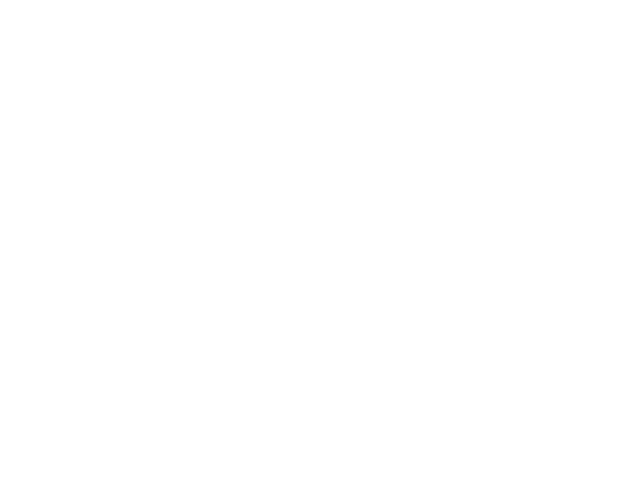

In [182]:
v_list = []
for i in range(200):
    v_list.append(mdac.ch57.voltage())
    
plt.figure()
plt.plot(v_list)

## Gate-Bias 2D sweep

In [95]:
yoko1_ramp(0)

{'yoko1_ramp': 0}

In [120]:
mdac.ch57.voltage()

0.0

In [126]:
#pinch-off variables (standard units: Volts, seconds, Ohms)
Vbegin = -0.5
Vend = 0.5
n_gate_points = 121
n_bias_points = 201
Rseries = 18.4e3
device_name = "SS3"

bias = 2e-3 #takes into account attenuation of 100.
lockin_amplitude = 10e-6 # real voltage on device
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key1.NPLC(keyNPLC)
    lockin1.amplitude(lockin_amplitude / attenuation) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin1_dc(-bias)
    lockin1.time_constant(time_constant)
    yoko1_ramp(Vbegin)
    time.sleep(10)
    
def cleanup(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    yoko1_ramp(0)

bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]
@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.5*time_constant)
    if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
        time.sleep(2)
    if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
        time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q383_upper_gate_vs_Bias_sweep/" + device_name,
    nest(
        sweep(yoko1_ramp, np.linspace(Vbegin, Vend, n_gate_points)),
        sweep(lockin1_dc, np.linspace(-bias, bias, n_bias_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup
) 

Starting experimental run with id: 71


In [127]:
#pinch-off variables (standard units: Volts, seconds, Ohms)
Vbegin = -0.4
Vend = -0.9
n_gate_points = 121
n_bias_points = 201
Rseries = 18.4e3
device_name = "SS3"

bias = 2e-3 #takes into account attenuation of 100.
lockin_amplitude = 10e-6 # real voltage on device
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key1.NPLC(keyNPLC)
    lockin1.amplitude(lockin_amplitude / attenuation) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin1_dc(-bias)
    lockin1.time_constant(time_constant)
    yoko1_ramp(Vbegin)
    time.sleep(10)
    
def cleanup(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    yoko1_ramp(0)

bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]
@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.5*time_constant)
    if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
        time.sleep(2)
    if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
        time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q383_upper_gate_vs_Bias_sweep/" + device_name,
    nest(
        sweep(yoko1_ramp, np.linspace(Vbegin, Vend, n_gate_points)),
        sweep(lockin1_dc, np.linspace(-bias, bias, n_bias_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup
) 

Starting experimental run with id: 72


In [94]:
#pinch-off variables (standard units: Volts, seconds, Ohms)
Vbegin = 0.4
Vend = 1
n_gate_points = 121
n_bias_points = 201
Rseries = 13.4e3
device_name = "SS6"

bias = 1e-3 #takes into account attenuation of 100.
lockin_amplitude = 5e-6 # real voltage on device
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key1.NPLC(keyNPLC)
    lockin1.amplitude(lockin_amplitude / attenuation) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin1_dc(-bias)
    lockin1.time_constant(time_constant)
    yoko1_ramp(Vbegin)
    time.sleep(10)
    
def cleanup(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
#     yoko1_ramp(0)

bias_ramp_stepsize = 2e-4  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]
@setter(("lockin1_dc", "V"))
def lockin1_dc(voltage): 
    voltage /= attenuation
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.5*time_constant)
    if np.abs(lockin1.sine_outdc() + bias/attenuation) < 1e-4:
        time.sleep(2)
    if np.abs(np.abs(lockin1.sine_outdc()) - 0.05) < 1.5*2*bias/(n_bias_points-1)/attenuation:
        time.sleep(4)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q383_TwoGates_vs_Bias_sweep/" + device_name,
    nest(
        sweep(yoko1_ramp, np.linspace(Vbegin, Vend, n_gate_points)),
        sweep(lockin1_dc, np.linspace(-bias, bias, n_bias_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup
) 

Starting experimental run with id: 61


In [275]:
TG2 = mdac.ch33
initialize(TG2)

#pinch-off variables (standard units: Volts, seconds, Ohms)
Vgate = 0.35
n_gate_points = 500
n_bias_points = 101
Rseries = 23e3
device_name = "NS_400"

Bias = 1e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key2.NPLC(keyNPLC)
    lockin2.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin2_dc(Bias)
    lockin2.time_constant(time_constant)
    mdac_TG2_voltage(Vgate)
    time.sleep(3)
    
def cleanup(): 
    lockin2.amplitude(0)
    lockin2_dc(0)
    mdac_TG2_voltage(Vgate)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        ('B_z', 'T')
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.7*time_constant)
    interval = 2*Bias/(n_bias_points-1)/attenuation # this interval is the distance btw two points
    if np.abs(lockin2.sine_outdc() - Bias/attenuation) < 0.5*interval:
        time.sleep(3)
    if np.abs(np.abs(lockin2.sine_outdc())-0.05) < 1.5*interval: # make this range larger than distance btw two points
        time.sleep(3)
        
    Bz = ami_z.field()
    key_raw1 = key2.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin2.amplitude()
    L1P     = lockin2.P()
    L1R     = lockin2.R()
    L1Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin2.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1, Bz
    return result

result = do_experiment(
    "Q326zz_Bias-TG_sweep_Bx_ramping_down/" + device_name,
    nest(
        #sweep(mdac_TG2_voltage, np.linspace(Vmin, Vmax, n_gate_points)),
        sweep(time_sweep, np.linspace(0, 1, 201)),
        sweep(lockin2_dc, np.linspace(Bias, -Bias, n_bias_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
)

Starting experimental run with id: 38


timeout: ('timed out', "asking 'FIELD:MAG?' to <AMI430: AMI430_z>", 'getting AMI430_z_field')

In [210]:
lockin2.X()

-7.2937984896e-07

In [278]:
CUT = mdac.ch49
initialize(CUT)

In [279]:
mdac_CUT_voltage(1)

{'mdac_CUT_voltage': 1}

In [277]:
mdac_PG_voltage(1)

{'mdac_PG_voltage': 1}

In [281]:
mdac_TG2_voltage(0.18)

{'mdac_TG2_voltage': 0.18}

In [280]:
TG2 = mdac.ch33
initialize(TG2)

#pinch-off variables (standard units: Volts, seconds, Ohms)
Vmin = 0.18
Vmax = 0.6
n_gate_points = 169
n_bias_points = 151
Rseries = 23e3
device_name = "NS_400"

Bias = 3e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key2.NPLC(keyNPLC)
    lockin2.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin2_dc(Bias)
    lockin2.time_constant(time_constant)
    mdac_TG2_voltage(Vmin)
    time.sleep(3)
    
def cleanup(): 
    lockin2.amplitude(0)
    lockin2_dc(0)
    mdac_TG2_voltage(Vmin)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.7*time_constant)
    interval = 2*Bias/(n_bias_points-1)/attenuation # this interval is the distance btw two points
    if np.abs(lockin2.sine_outdc() - Bias/attenuation) < 0.5*interval:
        time.sleep(3)
    if np.abs(np.abs(lockin2.sine_outdc())-0.05) < 1.5*interval: # make this range larger than distance btw two points
        time.sleep(3)
        
    #Bz = ami_z.field()
    key_raw1 = key2.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin2.amplitude()
    L1P     = lockin2.P()
    L1R     = lockin2.R()
    L1Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin2.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1#, Bz
    return result

result = do_experiment(
    "Q326zz_Bias-TG_sweep_Bx_ramping_down/" + device_name,
    nest(
        sweep(mdac_TG2_voltage, np.linspace(Vmin, Vmax, n_gate_points)),
        #sweep(time_sweep, np.linspace(0, 1, 201)),
        sweep(lockin2_dc, np.linspace(Bias, -Bias, n_bias_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
)

Starting experimental run with id: 39


### Bx - Bias sweep

In [251]:
ami_z.ramp_rate(0.7e-3)

In [274]:
ami_z.ramp_to(0)

In [265]:
ami_z.field()

5.9065732

In [247]:
TG2 = mdac.ch33
initialize(TG2)

#pinch-off variables (standard units: Volts, seconds, Ohms)
Vmin = 0.2
Vmax = 0.7
n_gate_points = 101
n_bias_points = 71
Rseries = 23e3
device_name = "NS_400"

Bias = 0.7e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key2.NPLC(keyNPLC)
    lockin2.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin2_dc(Bias)
    lockin2.time_constant(time_constant)
    mdac_TG2_voltage(Vmin)
    time.sleep(3)
    
def cleanup(): 
    lockin2.amplitude(0)
    lockin2_dc(0)
    mdac_TG2_voltage(0)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.3*time_constant)
    key_raw1 = key2.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin2.amplitude()
    L1P     = lockin2.P()
    L1R     = lockin2.R()
    L1Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin2.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_Bias-TG_sweep_Bx/" + device_name,
    nest(
        sweep(lockin2_dc, np.linspace(Bias, -Bias, n_bias_points)),
        sweep(mdac_TG2_voltage, np.linspace(Vmin, Vmax, n_gate_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
) 

Starting experimental run with id: 32


In [219]:
ami_x.ramp_rate(0.5e-3)

In [142]:
ami_x.field()

0.0098521

In [193]:
TG2 = mdac.ch33
initialize(TG2)

#pinch-off variables (standard units: Volts, seconds, Ohms)
gate = 0.35
n_bias_points = 101
Rseries = 23e3
device_name = "NS_400"

Bias = 1e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key2.NPLC(keyNPLC)
    lockin2.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin2_dc(Bias)
    lockin2.time_constant(time_constant)
    mdac_TG2_voltage(gate)
    time.sleep(3)
    
def cleanup(): 
    lockin2.amplitude(0)
    lockin2_dc(0)
    mdac_TG2_voltage(gate)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.3*time_constant)
    interval = 2*Bias/(n_bias_points-1)/attenuation # this interval is the distance btw two points
    if np.abs(lockin2.sine_outdc() - Bias/attenuation) < 0.5*interval:
        time.sleep(3)
    if np.abs(np.abs(lockin2.sine_outdc())-0.05) < 1.5*interval: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw1 = key2.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin2.amplitude()
    L1P     = lockin2.P()
    L1R     = lockin2.R()
    L1Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin2.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_Bx-Bias_sweep/" + device_name,
    nest(
        sweep(ami_x.field, np.linspace(0.2, 0.9, 71)),
        sweep(lockin2_dc, np.linspace(Bias, -Bias, n_bias_points)),
        #sweep(mdac_TG2_voltage, np.linspace(Vmin, Vmax, n_gate_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
) 

Starting experimental run with id: 9


In [ ]:
TG2 = mdac.ch33
initialize(TG2)

#pinch-off variables (standard units: Volts, seconds, Ohms)
gate = 0.5
n_bias_points = 101
Rseries = 23e3
device_name = "NS_400"

Bias = 1e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key2.NPLC(keyNPLC)
    lockin2.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin2_dc(Bias)
    lockin2.time_constant(time_constant)
    mdac_TG2_voltage(gate)
    time.sleep(3)
    
def cleanup(): 
    lockin2.amplitude(0)
    lockin2_dc(0)
    mdac_TG2_voltage(gate)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.3*time_constant)
    interval = 2*Bias/(n_bias_points-1)/attenuation # this interval is the distance btw two points
    if np.abs(lockin2.sine_outdc() - Bias/attenuation) < 0.5*interval:
        time.sleep(3)
    if np.abs(np.abs(lockin2.sine_outdc())-0.05) < 1.5*interval: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw1 = key2.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin2.amplitude()
    L1P     = lockin2.P()
    L1R     = lockin2.R()
    L1Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin2.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_Bx-Bias_sweep/" + device_name,
    nest(
        sweep(ami_x.field, np.linspace(0, 0.2, 21)),
        sweep(lockin2_dc, np.linspace(Bias, -Bias, n_bias_points)),
        #sweep(mdac_TG2_voltage, np.linspace(Vmin, Vmax, n_gate_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
) 

In [119]:
TG3 = mdac.ch10
initialize(TG3)

#pinch-off variables (standard units: Volts, seconds, Ohms)
Vmin = -0.3
Vmax = -0.1
n_gate_points = 101
n_bias_points = 151
Rseries = 13e3
device_name = "SQUID_320"

Bias = 1.5e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key3.NPLC(keyNPLC)
    lockin3.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin3_dc(Bias)
    lockin3.time_constant(time_constant)
    mdac_TG3_voltage(Vmin)
    time.sleep(3)
    
def cleanup(): 
    lockin3.amplitude(0)
    lockin3_dc(0)
    mdac_TG3_voltage(0)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.3*time_constant)
    key_raw1 = key3.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin3.amplitude()
    L1P     = lockin3.P()
    L1R     = lockin3.R()
    L1Y     = lockin3.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin3.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_Bias-TG_sweep/" + device_name,
    nest(
        sweep(lockin3_dc, np.linspace(Bias, -Bias, n_bias_points)),
        sweep(mdac_TG3_voltage, np.linspace(Vmin, Vmax, n_gate_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
) 

Starting experimental run with id: 26


In [121]:
TG3 = mdac.ch10
initialize(TG3)

#pinch-off variables (standard units: Volts, seconds, Ohms)
Vmin = -0.1
Vmax = 0.3
n_gate_points = 81
n_bias_points = 101
Rseries = 13e3
device_name = "SQUID_320"

Bias = 1e-3 #takes into account attenuation of 100.
lockin_amplitude = 1e-3 #to be attenuated by 100.
time_constant = 0.3

keyNPLC = 1
gain = 1e6
attenuation=1e-2

#pinch-off functions, from now on you don't have to change any parameter
def setup():    
    key3.NPLC(keyNPLC)
    lockin3.amplitude(lockin_amplitude) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin3_dc(Bias)
    lockin3.time_constant(time_constant)
    mdac_TG3_voltage(Vmin)
    time.sleep(3)
    
def cleanup(): 
    lockin3.amplitude(0)
    lockin3_dc(0)
    mdac_TG3_voltage(0)

@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        )
def measure_acdc(gain=gain, Rseries=Rseries, adder_atten=attenuation):
    time.sleep(1.3*time_constant)
    key_raw1 = key3.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin3.amplitude()
    L1P     = lockin3.P()
    L1R     = lockin3.R()
    L1Y     = lockin3.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin3.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
    
    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1
    return result

result = do_experiment(
    "Q326zz_Bias-TG_sweep/" + device_name,
    nest(
        sweep(lockin3_dc, np.linspace(Bias, -Bias, n_bias_points)),
        sweep(mdac_TG3_voltage, np.linspace(Vmin, Vmax, n_gate_points)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
) 

Starting experimental run with id: 28


### Ibias

In [141]:
yoko1.voltage_range(10.0)

In [142]:
yoko1_ramp(1.5)

{'yoko1_ramp': 1.5}

In [70]:
mdac_bias = 5e-3 # 1 MOhm of series resistance, so 1 V is converted to 1 uA
n_bias_points = 1001
keyNPLC = 10

def setup(): 
    key1.NPLC(keyNPLC)
    mdac_Bias_voltage(-mdac_bias) # 1 MOhm of series resistance, so 1 V is converted to 1 uA
    time.sleep(3)

def cleanup(): 
    mdac_Bias_voltage(0)
    
@getter(('V', 'V'), ('I_bias', 'A'), ('Rs', 'Ohm'), ('V_after_Rs_subtraction', 'V'),
       )
def measure_Ibias(Rseries=13.4e3, attenuation=1e-6):
    time.sleep(0.018*keyNPLC)
    V = key1.volt()
    I = mdac_Bias.voltage()*attenuation
    V_after_Rs_subtraction = V - I*Rseries
    
    result  =  V, I, Rseries, V_after_Rs_subtraction
    return result

result = do_experiment(
    "NIS_Ibias_4t_magnets_on/grounded_NIS_2",
    nest(
        sweep(mdac_Bias_voltage, np.linspace(-mdac_bias, mdac_bias, n_bias_points)),
        measure(measure_Ibias)
    ),
    setup,
    cleanup
)

Starting experimental run with id: 10


In [56]:
mdac.ch57.voltage()

0.0

In [144]:
Vbegin = 1.5
Vend = 1
n_gate_points = 26

mdac_bias = 1e-3 # 1 MOhm of series resistance, so 1 V is converted to 1 uA
n_bias_points = 201

keyNPLC = 10

def setup(): 
    key1.NPLC(keyNPLC)
    mdac_Bias_voltage(-mdac_bias) # 1 MOhm of series resistance, so 1 V is converted to 1 uA
    yoko1_ramp(Vbegin)
    time.sleep(3)

def cleanup(): 
    mdac_Bias_voltage(0)
    yoko1_ramp(0)
    
@getter(('V', 'V'), ('I_bias', 'A'), ('Rs', 'Ohm'), ('V_after_Rs_subtraction', 'V'),
       )
def measure_Ibias(Rseries=18.4e3, attenuation=1e-6):
    time.sleep(0.024*keyNPLC)
    V = key1.volt()
    I = mdac_Bias.voltage()*attenuation
    V_after_Rs_subtraction = V - I*Rseries
    
    result  =  V, I, Rseries, V_after_Rs_subtraction
    return result


bias_range = np.linspace(-mdac_bias, mdac_bias, n_bias_points)

result = do_experiment(
    "Q383_Ibias_sweep/SS3",
    nest(
        sweep(yoko1_ramp, np.linspace(Vbegin, Vend, n_gate_points)),
        sweep(mdac_Bias_voltage, bias_range),
        measure(measure_Ibias)
    ),
    setup,
    cleanup
)



Starting experimental run with id: 77


KeyboardInterrupt: 

In [58]:
mdac.ch57.voltage()

0.0

In [57]:
mdac_Bias = mdac.ch57
initialize(mdac_Bias)

In [234]:
Vmin = 0.3
Vmax = 1
n_gate_points = 36
Bias = 2e-3 # 1 MOhm of series resistance, so 1 V is converted to 1 uA
n_bias_points = 201
keyNPLC = 10

def setup(): 
    key3.NPLC(keyNPLC)
    mdac_Bias_voltage(-Bias) # 1 MOhm of series resistance, so 1 V is converted to 1 uA
    mdac_PG_voltage(Vmin)
    time.sleep(3)

def cleanup(): 
    mdac_PG_voltage(Vmax)
    mdac_Bias_voltage(0)
    
@getter(('V', 'V'), ('I_bias', 'A'), ('Rs', 'Ohm'), ('V_after_Rs_subtraction', 'V'),
       )
def measure_Ibias(Rseries=13.4e3, attenuation=1e-6):
    time.sleep(0.018*keyNPLC)
    V = key3.volt()
    I = mdac_Bias.voltage()*attenuation
    V_after_Rs_subtraction = V - I*Rseries
    
    result  =  V, I, Rseries, V_after_Rs_subtraction
    return result

result = do_experiment(
    "Q326zz_Gate-Ibias_sweep/SS_SideUp_200_B".format(gate),
    nest(
        sweep(mdac_PG_voltage, np.linspace(Vmin, Vmax, n_gate_points)),
        sweep(mdac_Bias_voltage, np.linspace(-Bias, Bias, n_bias_points)),
        measure(measure_Ibias)
    ),
    setup,
    cleanup,
    live_plot=False
)

Starting experimental run with id: 23


In [106]:
def setup(): 
    key1.NPLC(10)
    mdac_Bias_voltage(-1e-3)
    mdac_CUT_voltage(0.3)
    lockin1.sine_outdc(0) 
    lockin1.amplitude(0)     # 1 MOhm of series resistance, so 1 V is converted to 1 uA
    lockin1.time_constant(0.1)
    time.sleep(3)

def cleanup(): 
    lockin1.amplitude(0)
    lockin1.sine_outdc(0)
    mdac_CUT_voltage(0.6)
    
#('Lockin1_excitation', 'A'), ('g', '2e^2/h'), ('R', 'Ohm'),
#        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'),

@getter(('Voltage', 'V'), 
       )
def measure_Ibias(Rseries=18e3, attenuation=1e-6):
    time.sleep(0.17)
    #Iac     = attenuation*lockin1.amplitude() #Ampere
    key_raw1 = key1.volt()
    #L1P     = lockin1.P()
    #L1R     = lockin1.R()
    #L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    #L1X     = lockin1.X()  
    #R = L1X/Iac - Rseries # Ohm
    #try:
    #    g = 12906/R #[2e^2/h]
    #except ZeroDivisionError:
    #    g = 0
        
    
    result  =  key_raw1 #, Iac, g, R, L1X, L1Y, L1R, L1P
    return result

result = do_experiment(
    "Q326zz_Ibias-Gate_sweep/SS_230",
    nest(
        sweep(mdac_Bias_voltage, np.linspace(-1e-3, 1e-3, 201)),
        sweep(mdac_CUT_voltage, np.linspace(0, 0.3, 61)),
        measure(measure_Ibias)
    ),
    setup,
    cleanup,
    live_plot=False
)

Starting experimental run with id: 16


KeyboardInterrupt: 

In [38]:
mdac_CUT_voltage(0)
#mdac_PG_voltage(0)

{'mdac_CUT_voltage': 0}

### Gate stability

In [ ]:
@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),)

def measure_acdc(gain=1e6, Rseries=18e3, adder_atten=1):
    time.sleep(0.1)
#     if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
#         time.sleep(3)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0

    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, 
    return result

@setter(("time_sweep_real", "s"))
def time_sweep_real(a): 
    time.sleep(0.001)
    
def time_window(t0, count): # yields the time difference between the current time and some initial time t0
    for kk in range(count):
        yield time.time() - t0

lockin1.time_constant(0.03)

def setup1():    
    key1.NPLC(1)
    mdac_PG_voltage(-0.5)
    lockin1_dc(0)    # voltage you want to apply (takes into account attenuation 100)
    lockin1.amplitude(10e-6) # to be attenuated by 100. So 10uV excitation when this is 1mV
    mdac_PG_voltage(0.1)
    time.sleep(20)

def cleanup1(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    mdac_PG_voltage(0)

result = do_experiment(
    "Q243_Vbias_gate_stability_0bias_lockinTimeConstant={}s/QPC2".format(lockin1.time_constant()),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_PG_voltage, np.linspace(0.1, 0.3, 51)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        sweep(time_sweep, np.linspace(0, 1, 201)),
        measure(measure_acdc)
    ),
    setup1,
    cleanup1,
    live_plot=False
) 

lockin1.time_constant(0.1)

result = do_experiment(
    "Q243_Vbias_gate_stability_0bias_lockinTimeConstant={}s/QPC2".format(lockin1.time_constant()),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_PG_voltage, np.linspace(0.1, 0.3, 51)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        sweep(time_sweep, np.linspace(0, 1, 201)),
        measure(measure_acdc)
    ),
    setup1,
    cleanup1,
    live_plot=False
) 

In [195]:
@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),)

def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1):
    time.sleep(0.1)
#     if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
#         time.sleep(3)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0

    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, 
    return result

@setter(("time_sweep_real", "s"))
def time_sweep_real(a): 
    time.sleep(0.001)
    
def time_window(t0, count): # yields the time difference between the current time and some initial time t0
    for kk in range(count):
        yield time.time() - t0

lockin1.time_constant(0.03)

def setup1():    
    key1.NPLC(1)
    mdac_PG_voltage(-0.5)
    lockin1_dc(0)    # voltage you want to apply (takes into account attenuation 100)
    lockin1.amplitude(10e-6) # to be attenuated by 100. So 10uV excitation when this is 1mV
    mdac_PG_voltage(0.1)
    time.sleep(20)

def cleanup1(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    mdac_PG_voltage(0)

result = do_experiment(
    "Q243_Vbias_gate_stability_0bias_lockinTimeConstant={}s/QPC2".format(lockin1.time_constant()),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_PG_voltage, np.linspace(0.1, 0.3, 51)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        sweep(time_sweep, np.linspace(0, 1, 201)),
        measure(measure_acdc)
    ),
    setup1,
    cleanup1,
    live_plot=False
) 

lockin1.time_constant(0.1)

result = do_experiment(
    "Q243_Vbias_gate_stability_0bias_lockinTimeConstant={}s/QPC2".format(lockin1.time_constant()),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_PG_voltage, np.linspace(0.1, 0.3, 51)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        sweep(time_sweep, np.linspace(0, 1, 201)),
        measure(measure_acdc)
    ),
    setup1,
    cleanup1,
    live_plot=False
) 


Starting experimental run with id: 14
Starting experimental run with id: 15


In [197]:
@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'))
def measure_dc(gain=1e6, Rseries=13e3, adder_atten=1):
    time.sleep(0.03)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    
    result  = current_dc1, key_raw1 
    return result


@setter(("time_sweep_real", "s"))
def time_sweep_real(a): 
    time.sleep(0.001)
    
def time_window(t0, count): # yields the time difference between the current time and some initial time t0
    for kk in range(count):
        yield time.time() - t0

def setup1():    
    key1.NPLC(1)
    mdac_PG_voltage(-0.5)
    lockin1_dc(0.01)    # voltage you want to apply (takes into account attenuation 100)
    lockin1.amplitude(0) # to be attenuated by 100. So 10uV excitation when this is 1mV
    mdac_PG_voltage(0.1)
    time.sleep(20)

def cleanup1(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    mdac_PG_voltage(0)

result = do_experiment(
    "Q243_Vbias_gate_stability_10mVbias/QPC2".format(lockin1.time_constant()),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_PG_voltage, np.linspace(0.1, 0.3, 51)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        sweep(time_sweep, np.linspace(0, 1, 201)),
        measure(measure_acdc)
    ),
    setup1,
    cleanup1,
    live_plot=False
) 



Starting experimental run with id: 17


### Gate sweep forth & back

In [168]:
@getter(('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),)

def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1):
    time.sleep(0.1)
    if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0

    result  = current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, 
    return result

sample_name = 'QPC2'
min_PG = -0.5
max_PG = 1
lockin_dc = 10e-3    #V

points = int(50*(max_PG - min_PG) + 1)

def setup1():    
    key1.NPLC(1)
    lockin1_dc(lockin_dc)    # voltage you want to apply (takes into account attenuation 100)
    lockin1.amplitude(10e-6) # to be attenuated by 100. So 10uV excitation when this is 1mV
    mdac_PG_voltage(min_PG)
    time.sleep(20)

def cleanup1(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    mdac_PG_voltage(max_PG)

result = do_experiment(
    "Q243_Vbias_pinchoff_{}mV_bias/{}".format(int(lockin_dc*1000), sample_name),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_PG_voltage, np.linspace(min_PG, max_PG, points)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        measure(measure_acdc)
    ),
    setup1,
    cleanup1,
    live_plot=False
) 

def setup2():    
    key1.NPLC(1)
    lockin1_dc(lockin_dc)    # voltage you want to apply (takes into account attenuation 100)
    lockin1.amplitude(10e-6)
    mdac_PG_voltage(max_PG)
    time.sleep(1)

def cleanup2(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    mdac_PG_voltage(0)

result = do_experiment(
    "Q243_Gate_sweep_backward_{}mV_bias/{}".format(int(lockin_dc*1000), sample_name),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_PG_voltage, np.linspace(max_PG, min_PG, points)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        measure(measure_acdc)
    ),
    setup2,
    cleanup2,
    live_plot=False
)

Starting experimental run with id: 6
Starting experimental run with id: 7


In [97]:
def setup():    
    key1.NPLC(1)
    key2.NPLC(1)
    lockin1.amplitude(2e-3) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin2.amplitude(2e-3) # to be attenuated by 100. So 10uV excitation when this is 1mV
    time.sleep(3)

def cleanup(): 
    lockin1.amplitude(0)
    lockin2.amplitude(0)
    lockin1_dc(0)
    lockin2_dc(0)

@getter(('B_x', 'T'), ('current1', 'A'), ('raw_voltage_dc1', 'V'), ('conductance1', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'),
        ('current2', 'A'), ('raw_voltage_dc2', 'V'), ('conductance2', '2e^2/h'),
        ('Lockin2_X', 'V'), ('Lockin2_Y', 'V'), ('Lockin2_R', 'V'),
        ('Lockin2_phase', 'deg'), ('Lockin2_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1e-2):
    B_x = ami_x.field()
#     if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
#         time.sleep(3)
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    Vac1     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g1 = 12906/(Vac1/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g1 = 0
#     if np.abs(np.abs(lockin2.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
#         time.sleep(3)
    key_raw2 = key2.volt()
    current_dc2 = -key_raw2/gain
    Vac2     = adder_atten*lockin2.amplitude()
    L2P     = lockin2.P()
    L2R     = lockin2.R()
    L2Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L2X     = lockin2.X()
    current_ac = L2X/gain    
    try:
        g2 = 12906/(Vac2/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g2 = 0

    result  = B_x, current_dc1, key_raw1, g1, L1X, L1Y, L1R, L1P, Vac1, current_dc2, key_raw2, g2, L2X, L2Y, L2R, L2P, Vac2
    return result

mdac_PG_voltage(0)
mdac_CUT_voltage(0)
Gate = [0, 0.3, 0.6, 0.9, 1.2]
lockin_DC = [0]
for i, G in enumerate(Gate):
    for j, DC in enumerate(lockin_DC):
        mdac_PG_voltage(G)
        mdac_CUT_voltage(G)
        lockin1_dc(DC)
        lockin2_dc(DC)
        result = do_experiment(
            "Q243_field_sweep_Gate_{}V_Bias_{}V/FEM1_A1D11_FEM3_D6D4".format(G, DC),
            nest(
                #sweep(lockin1.frequency, np.linspace(7,131, 20)),
                #sweep(mdac_CUT_voltage, np.linspace(-0.5, 1, 151)),
                sweep(field_sweep, field_window(ami_x, -0.2, 0.2)),
                #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
                measure(measure_acdc)
            ),
            setup,
            cleanup,
            live_plot=False
        ) 

lockin1.amplitude(0)
lockin2.amplitude(0)
lockin1_dc(0)
lockin2_dc(0)
mdac_PG_voltage(0)
mdac_CUT_voltage(0)

Starting experimental run with id: 17
Initializing (blocking) field to 0.2 T ...
Sweeping (non-blocking) field to -0.2 T ...
Starting experimental run with id: 18
Initializing (blocking) field to -0.2 T ...
Sweeping (non-blocking) field to 0.2 T ...
Starting experimental run with id: 19
Initializing (blocking) field to 0.2 T ...
Sweeping (non-blocking) field to -0.2 T ...
Starting experimental run with id: 20
Initializing (blocking) field to -0.2 T ...
Sweeping (non-blocking) field to 0.2 T ...
Starting experimental run with id: 21
Initializing (blocking) field to 0.2 T ...
Sweeping (non-blocking) field to -0.2 T ...


{'mdac_CUT_voltage': 0}

### pinch-offs at 4K

In [27]:
ami_x.ramp_to(0)

In [30]:
def mdac_PG_TLM2_voltage_raw(voltage): 
    ramp(PG_TLM2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_PG_TLM2_voltage = setter(("mdac_PG_TLM2_B6B5_voltage", "V"))(mdac_PG_TLM2_voltage_raw)

def mdac_PG_FEM3_voltage_raw(voltage): 
    ramp(PG_FEM3.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_PG_FEM3_voltage = setter(("mdac_PG_FEM3_D6D4_voltage", "V"))(mdac_PG_FEM3_voltage_raw)

def mdac_PG_FEM1_voltage_raw(voltage): 
    ramp(PG_FEM1.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_PG_FEM1_voltage = setter(("mdac_PG_FEM1_A1D11_voltage", "V"))(mdac_PG_FEM1_voltage_raw)

def mdac_3GATES_voltage_raw(voltage):
    ramp(PG_TLM2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    ramp(PG_FEM3.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
    ramp(PG_FEM1.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)    
mdac_3GATES_voltage = setter(("mdac_3GATES_voltage", "V"))(mdac_3GATES_voltage_raw)


In [55]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [53]:
PG_TLM2 = mdac.ch49
initialize(PG_TLM2)

PG_FEM3 = mdac.ch01
initialize(PG_FEM3)

PG_FEM1 = mdac.ch09
initialize(PG_FEM1)

In [41]:
@getter(('current2', 'A'), ('raw_voltage_dc2', 'V'), ('conductance2', '2e^2/h'), 
        ('L2_X', 'V'), ('L2_Y', 'V'), ('L2_R', 'V'), ('L2_phase', 'deg'), ('L2_excit', 'V'),
        ('current3', 'A'), ('raw_voltage_dc3', 'V'), ('conductance3', '2e^2/h'), 
        ('L3_X', 'V'), ('L3_Y', 'V'), ('L3_R', 'V'), ('L3_phase', 'deg'), ('L3_excit', 'V'),
        ('current4', 'A'), ('raw_voltage_dc4', 'V'), ('conductance4', '2e^2/h'), 
        ('L4_X', 'V'), ('L4_Y', 'V'), ('L4_R', 'V'), ('L4_phase', 'deg'), ('L4_excit', 'V'),
       )

def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1e-2):
    time.sleep(0.1)
    
    if np.abs(np.abs(lockin2.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw1 = key1.volt()
    current_dc2 = -key_raw1/gain
    Vac2     = adder_atten*lockin2.amplitude()
    L2P     = lockin2.P()
    L2R     = lockin2.R()
    L2Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L2X     = lockin2.X()
    current2_ac = L2X/gain    
    try:
        g2 = 12906/(Vac2/current2_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g2 = 0
        
    if np.abs(np.abs(lockin3.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw2 = key2.volt()
    current_dc3 = -key_raw2/gain
    Vac3     = adder_atten*lockin3.amplitude()
    L3P     = lockin3.P()
    L3R     = lockin3.R()
    L3Y     = lockin3.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L3X     = lockin3.X()
    current3_ac = L3X/gain    
    try:
        g3 = 12906/(Vac3/current3_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g3 = 0
    
    if np.abs(np.abs(lockin4.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw3 = key3.volt()
    current_dc4 = -key_raw3/gain
    Vac4     = adder_atten*lockin4.amplitude()
    L4P     = lockin4.P()
    L4R     = lockin4.R()
    L4Y     = lockin4.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L4X     = lockin4.X()
    current4_ac = L4X/gain    
    try:
        g4 = 12906/(Vac4/current4_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g4 = 0

    result  = current_dc2, key_raw1, g2, L2X, L2Y, L2R, L2P, Vac2, current_dc3, key_raw2, g3, L3X, L3Y, L3R, L3P, Vac3, current_dc4, key_raw3, g4, L4X, L4Y, L4R, L4P, Vac4
    return result

sample_name = 'TLM2_FEM3_FEM1'
min_PG = -0.2
max_PG = 1.2
lockin_dc = 10e-3    #V voltage you want to apply (takes into account attenuation 100)
lockin_ac = 10e-6*100   #V to be attenuated by 100. So 10uV excitation when this is 1mV

points = int(200*(max_PG - min_PG) + 1)

def setup1():    
    key1.NPLC(1)
    key2.NPLC(1)
    key3.NPLC(1)
    lockin2_dc(lockin_dc)    # voltage you want to apply (takes into account attenuation 100)
    lockin2.amplitude(lockin_ac) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin3_dc(lockin_dc)    # voltage you want to apply (takes into account attenuation 100)
    lockin3.amplitude(lockin_ac) # to be attenuated by 100. So 10uV excitation when this is 1mV
    lockin4_dc(lockin_dc)    # voltage you want to apply (takes into account attenuation 100)
    lockin4.amplitude(lockin_ac) # to be attenuated by 100. So 10uV excitation when this is 1mV
    mdac_PG_TLM2_voltage(min_PG)
    mdac_PG_FEM3_voltage(min_PG)
    mdac_PG_FEM1_voltage(min_PG)
    time.sleep(3)

def cleanup1(): 
    mdac_PG_TLM2_voltage(max_PG)
    mdac_PG_FEM3_voltage(max_PG)
    mdac_PG_FEM1_voltage(max_PG)

result = do_experiment(
    "Q243_Gate_sweep_{}mV_bias/{}".format(int(lockin_dc*1000), sample_name),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_3GATES_voltage, np.linspace(min_PG, max_PG, points)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        measure(measure_acdc)
    ),
    setup1,
    cleanup1,
    live_plot=False
) 

def setup2():   
    mdac_PG_TLM2_voltage(max_PG)
    mdac_PG_FEM3_voltage(max_PG)
    mdac_PG_FEM1_voltage(max_PG)
    time.sleep(1)

def cleanup2(): 
    lockin2_dc(0)
    lockin2.amplitude(0)
    lockin3_dc(0)
    lockin3.amplitude(0)
    lockin4_dc(0)
    lockin4.amplitude(0)
    mdac_PG_TLM2_voltage(0)
    mdac_PG_FEM3_voltage(0)
    mdac_PG_FEM1_voltage(0)

result = do_experiment(
    "Q243_Gate_sweep_backward_{}mV_bias/{}".format(int(lockin_dc*1000), sample_name),
    nest(
        #sweep(lockin1.frequency, np.linspace(7,131, 20)),
        sweep(mdac_3GATES_voltage, np.linspace(max_PG, min_PG, points)),
        #sweep(field_sweep, field_window(ami_x, -0.9, 0.9)),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 101)),
        measure(measure_acdc)
    ),
    setup2,
    cleanup2,
    live_plot=False
)

Starting experimental run with id: 21
Starting experimental run with id: 22


### Gate and bias

In [46]:
def setup():    
    key1.NPLC(1)
    mdac_PG_voltage(-0.2)
    lockin_dc(-20e-3)            # voltage you want to apply (takes into account attenuation 100)
    lockin1.amplitude(2e-3)     # to be attenuated by 100. So 10uV excitation when this is 1mV
    time.sleep(3)

def cleanup(): 
    lockin1.amplitude(0)
    lockin_dc(0)
    mdac_PG_voltage(0)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1e-2):
    time.sleep(0.1)
    if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    Vac     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g = 0

    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result


result = do_experiment(
    "Q243_Gate_vs_Bias_5.5T/QPC3_A7A9",
    nest(
        #sweep(lockin1.frequency, np.linspace(7,))
        #sweep(ami_z.field, np.linspace(0, 5.5, 55)),
        sweep(mdac_PG_voltage, np.linspace(-0.2, 0.5, 401)),
        #sweep(mdac_PG_voltage, np.concatenate((np.linspace(-0.2, 0.8, 101), np.linspace(0.8, -0.2, 101)))),
        sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 151)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=False
)

Starting experimental run with id: 15


In [47]:
def setup():    
    key1.NPLC(1)
    mdac_PG_voltage(-0.2)
    lockin_dc(0)            # voltage you want to apply (takes into account attenuation 100)
    lockin1.amplitude(2e-3)     # to be attenuated by 100. So 10uV excitation when this is 1mV
    time.sleep(3)

def cleanup(): 
    lockin1.amplitude(0)
    lockin_dc(0)
    mdac_PG_voltage(0)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1e-2):
    time.sleep(0.1)
    if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    Vac     = adder_atten*lockin1.amplitude()
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g = 0

    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result


result = do_experiment(
    "Q243_Gate_vs_Field_0Bias/QPC3_A7A9",
    nest(
        #sweep(lockin1.frequency, np.linspace(7,))
        sweep(ami_z.field, np.linspace(5.5, 0, 55)),
        sweep(mdac_PG_voltage, np.linspace(-0.2, 0.5, 401)),
        #sweep(mdac_PG_voltage, np.concatenate((np.linspace(-0.2, 0.8, 101), np.linspace(0.8, -0.2, 101)))),
        #sweep(lockin_dc, np.linspace(-20e-3, 20e-3, 151)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=False
)

Starting experimental run with id: 16


## I-bias

In [128]:
ami_x.ramp_rate(0.4e-3)

In [198]:
ami_x.ramp_to(0.99)

In [130]:
ami_x.field()

-0.0271472

In [78]:
mdac_PG_voltage(0)

{'mdac_PG_voltage': 0}

## Bx-Gate sweep for Hall mobility (blocking field)

In [77]:
ami_x.ramp_rate(0.4e-3)
timeconst = 0.1

def setup():    
    mdac_PG_voltage(-0.5)
    lockin1_dc(0)
    lockin1.amplitude(3e-3)     # 1 MOhm of series resistance, so 1 V is converted to 1 uA
    lockin1.time_constant(timeconst)
    lockin2.time_constant(timeconst)
    lockin3.time_constant(timeconst)
    lockin4.time_constant(timeconst)
    time.sleep(3)

def cleanup(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    mdac_PG_voltage(0)

@getter(('Lockin1_excitation', 'A'), 
        ('g_xx_12up', '2e^2/h'), ('g_xy_junction2', '2e^2/h'), ('g_xx_23down', '2e^2/h'), ('g_xy_junction3', '2e^2/h'),
        ('R_xx_12up', 'Ohm'), ('R_xy_junction2', 'Ohm'), ('R_xx_23down', 'Ohm'), ('R_xy_junction3', 'Ohm'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), 
        ('Lockin2_X', 'V'), ('Lockin2_Y', 'V'), ('Lockin2_R', 'V'), ('Lockin2_phase', 'deg'),
        ('Lockin3_X', 'V'), ('Lockin3_Y', 'V'), ('Lockin3_R', 'V'), ('Lockin3_phase', 'deg'),
        ('Lockin4_X', 'V'), ('Lockin4_Y', 'V'), ('Lockin4_R', 'V'), ('Lockin4_phase', 'deg'),
       )
def measure_Ibias(Rseries=13e3, attenuation=1e-6):
    time.sleep(1.2*timeconst)
    Iac     = attenuation*lockin1.amplitude() #Ampere
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()  
    Rxx12up = L1X/Iac # Ohm
    try:
        gxx12up = 12906/Rxx12up #[2e^2/h]
    except ZeroDivisionError:
        gxx12up = 0
        
    L2P     = lockin2.P()
    L2R     = lockin2.R()
    L2Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L2X     = lockin2.X()  
    Rxy_junction2 = L2X/Iac # Ohm
    try:
        gxy_junction2 = 12906/Rxy_junction2 #[2e^2/h]
    except ZeroDivisionError:
        gxy_junction2 = 0
        
    L3P     = lockin3.P()
    L3R     = lockin3.R()
    L3Y     = lockin3.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L3X     = lockin3.X()  
    Rxx23down = L3X/Iac # Ohm
    try:
        gxx23down = 12906/Rxx23down #[2e^2/h]
    except ZeroDivisionError:
        gxx23down = 0

    L4P     = lockin4.P()
    L4R     = lockin4.R()
    L4Y     = lockin4.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L4X     = lockin4.X()  
    Rxy_junction3 = L4X/Iac # Ohm
    try:
        gxy_junction3 = 12906/Rxy_junction3 #[2e^2/h]
    except ZeroDivisionError:
        gxy_junction3 = 0
    
    result  =  Iac, gxx12up, gxy_junction2, gxx23down, gxy_junction3, Rxx12up, Rxy_junction2, Rxx23down, Rxy_junction3, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, L3X, L3Y, L3R, L3P, L4X, L4Y, L4R, L4P
    return result

result = do_experiment(
    "Q243_Bx-Gate_sweep/HB",
    nest(
        sweep(ami_x.field, np.linspace(-0.99, 0.99, 100)),
        sweep(mdac_PG_voltage, np.concatenate((np.linspace(-0.5, 1, 301), np.linspace(1, -0.5, 301)))),
        measure(measure_Ibias)
    ),
    setup,
    cleanup,
    live_plot=False
)

Starting experimental run with id: 4


## Bx-Gate sweep for WAL

In [80]:
ami_x.ramp_rate(0.45e-3)
ami_x.ramp_to(0.1)
time.sleep(2000)

def setup():    
    mdac_PG_voltage(-0.1)
    lockin1_dc(0) # voltage you want to apply (takes into account attenuation 100)
    lockin1.amplitude(2e-3)     # 1 MOhm of series resistance, so 1 V is converted to 1 uA
    lockin1.time_constant(0.3)
    lockin3.time_constant(0.3)
    time.sleep(3)

def cleanup(): 
    lockin1.amplitude(0)
    lockin1_dc(0)
    mdac_PG_voltage(0)

@getter(('Lockin1_excitation', 'A'), 
        ('g_xx_12up', '2e^2/h'), ('g_xx_23down', '2e^2/h'),
        ('R_xx_12up', 'Ohm'), ('R_xx_23down', 'Ohm'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), 
        ('Lockin3_X', 'V'), ('Lockin3_Y', 'V'), ('Lockin3_R', 'V'), ('Lockin3_phase', 'deg'),
       )
def measure_Ibias(Rseries=13e3, attenuation=1e-6):
    time.sleep(0.3)
    Iac     = attenuation*lockin1.amplitude() #Ampere
    L1P     = lockin1.P()
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()  
    Rxx12up = L1X/Iac # Ohm
    try:
        gxx12up = 12906/Rxx12up #[2e^2/h]
    except ZeroDivisionError:
        gxx12up = 0
        
    L3P     = lockin3.P()
    L3R     = lockin3.R()
    L3Y     = lockin3.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L3X     = lockin3.X()  
    Rxx23down = L3X/Iac # Ohm
    try:
        gxx23down = 12906/Rxx23down #[2e^2/h]
    except ZeroDivisionError:
        gxx23down = 0
    
    result  =  Iac, gxx12up, gxx23down, Rxx12up, Rxx23down, L1X, L1Y, L1R, L1P, L3X, L3Y, L3R, L3P
    return result

result = do_experiment(
    "Q243_Bx-Gate_sweep/HB",
    nest(
        sweep(ami_x.field, np.linspace(0.10, -0.10, 201)),
        sweep(mdac_PG_voltage, np.concatenate((np.linspace(-0.1, 0.8, 181), np.linspace(0.8, -0.1, 181)))),
        measure(measure_Ibias)
    ),
    setup,
    cleanup,
    live_plot=False
)

Starting experimental run with id: 2


## Leakage test

In [132]:
yoko1.voltage()

1.0

In [133]:
yoko1_ramp(0)

{'yoko1_ramp': 0}

In [90]:
def setup():
    key1.NPLC(1) # NPLC=1 -> 16.667 ms
    yoko1_ramp(1)
    time.sleep(3)

def cleanup():
    pass
    #yoko1_ramp(0)
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'))
def measure_dc(gain=1e7):
    time.sleep(0.2)
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    
    result  = current_dc, key_raw
    return result

result = do_experiment(
    "Q383_leakage_test/SS7",
    nest(
        sweep(yoko1_ramp, np.linspace(1, 1.5, 101)),
        measure(measure_dc)
    ),
    setup,
    cleanup,
    live_plot=False
)

Starting experimental run with id: 56


ValueError: ('Desired output level not in range [-1.0, 1.0]', 'setting yoko1_voltage to 1.005')